# Recommender system using Pyspark (ALS algorithm)
---


## Introduction

Recommender Systems are algorithms designed to make suggestions of items to users of a certain platform based on their previous patterns. They are used in the tech industry by companies such as Netflix, Youtube, Facebook, Amazon, Expedia, Spotfy and so on. 
More recently, recommender systems have become more diffuse and are not limited to big tech companies but virtually every company can create its own system (with the right dataset). 
<br><br>
The benefits of usign such systems are huge, as described [here](https://towardsdatascience.com/5-advantages-recommendation-engines-can-offer-to-businesses-10b663977673), [here](https://medium.com/@triconinfotech/improving-customer-engagement-with-recommender-systems-b423bdbb4e55) and [here](https://neoteric.eu/blog/how-to-boost-sales-with-a-recommender-system/).  In a nutshell, it can drive traffic, deliver personalized content, enhance customer engagement, increase sales and much more. <br>

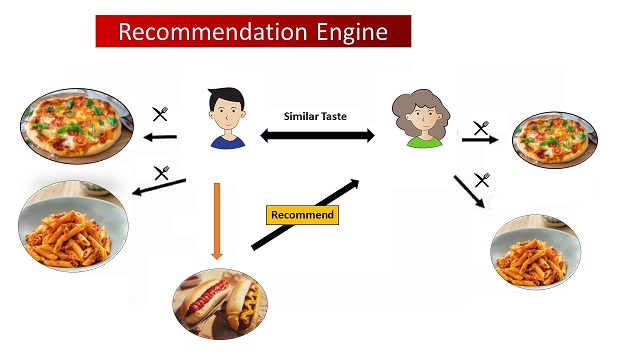

The architecture of the recommendation engine is dependent on the business domain and the attributes of the dataset at one's disposal. For instance, customers on Ebay frequently provide ratings for products scaling on 1 (unhappy) to 5 (very happy). Spotfy hold information of the gender of music one listens to. Uber eats should know what is your favorite type of food. Istagram has user patterns of likes in images. Such data sources document interactions between users and products (items). In addition, the platform may access personal information from users, such as their location, age, sex and so on. Not to mention the complete metadata of their items.

There are three especially commom methods to design a recommender system. `Collaborative Filtering`, `Content-based Filtering` and `hybrid techniques`. Content-based systems aims to make recommendation based on some previous information about the customer and the products. For instance if Netflix knows you like drama movies it might recommend you movies of this gender. However, in a collaborative filtering approach it might simply ignore the gender of the movie. The features used in this case are exclusevely users rating patterns. For instance if you whatched 5 different series on Netflix and have rated 5 each of them, just like some other random user, than you might be interested to know what else he was rated as 5 stars. Hybrid systems make use of both techniques. 
<br><br>
in this project we will use of Alternating Least Square Matrix Factorization,a Collaborative Filtering algorithm. We will build a recommeder system for restaurants in the city of Toronto.


#### Requirements:
- Python 
- Apache Spark

## Import Libraries and Initialize spark session

In [1]:
!pip install pyspark

     |████████████████████████████████| 204.7 MB 14 kB/s s eta 0:00:01
     |████████████████████████████████| 198 kB 52.7 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=bd5ff442cfd1c505189bb471e474a078494a0cfe3d47a029624a159a23a84d73
  Stored in directory: /root/.cache/pip/wheels/4e/c5/36/aef1bb711963a619063119cc032176106827a129c0be20e301
Successfully built pyspark


In [2]:
#import libraries
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
appName="Collaborative Filtering with PySpark"

#initialize the spark session
spark = SparkSession.builder.appName(appName).getOrCreate()

#get sparkcontext from the sparksession
sc = spark.sparkContext
sqlContext = SQLContext(sc)

## Load Dataset in Apache Spark


### Dataset
We will be working with yelp [dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset). It constains millions of reviews of businessess across the world. We will limit ourselves with the restaurants in the city of Toronto, Canada. The relevant files for us are the following:

`yelp_academic_dataset_business.json:`Contains information about every review made every customer for every business (millions of reviews). <br>
`yelp_academic_dataset_review.json:` Contains multiple characteristics from businesses such as `parking available`, `type of food`, etc. 

### Spark SQL

Since we are working with json files we use the function `read.json`. It takes a json file and transform it to a dataframe. We use `sqlContext`from the module Spark SQL. Spark SQL is a Spark module for structured data processing. It allows use to perform SQL queries in dataframes such as `join`, `groupby` `select` and so on. 

In [4]:
df_business = sqlContext.read.json('../input/yelp-dataset/yelp_academic_dataset_business.json')
df_review = sqlContext.read.json('/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json')

## Filter Rows and columns

Our dataset contains many columns and most won't be used in this project. From the table `df_business` we want only the most important features of businesses such as the `id`, `name`, `stars`, `category` and so on. We are exclusevely interested in businesses that are restaurants and in the city of Toronto. Therefore we apply the function `filter` in the columns city and `category` to enforce this restriction. 

From the table `df_review` we want only the reviews from the selected table above. We use an `inner join` of `df_review` and `df_business` to elimate all other businesses from the table reviews.



In [5]:
df_business = df_business.select("business_id","name", "stars", 
                                 "review_count", "attributes", 
                                 "categories", "city").withColumnRenamed("stars", "stars_restaurant")

df_business = df_business.filter((df_business['city'] == 'Toronto') & (df_business.categories.contains('Restaurants'))).drop('city')

In [6]:
df_review = df_review.join(df_business, on='business_id', how='inner')

Lets make a quick visualisation to the basic elements of our review table.

In [7]:
df_review.select(['business_id', 'user_id', 'stars']).show()

+--------------------+--------------------+-----+
|         business_id|             user_id|stars|
+--------------------+--------------------+-----+
|qUWqjjjfpB2-4P3He...|TZQSUDDcA4ek5gBd6...|  4.0|
|9Eghhu_LzEJgDKNgi...|iFEM16O5BeKvf_AHs...|  3.0|
|cDoo0Pf1d_P79Rq3Z...|1kNsEAhGU8d8xugMu...|  3.0|
|4m_hApwQ054v3ue_O...|Eg_VTAQwK3CxYTORN...|  5.0|
|jM6JjZXFAQQANwdlE...|IIE2OX5haarGNefY2...|  5.0|
|PMPMHHLe9vFzcR67i...|RRhco4irDXPk5EJmv...|  5.0|
|IfUkm42SB9D0m_Zbk...|Kl6jNDAE7PG_VVQaf...|  4.0|
|NrJSy3dgcXErFtOKG...|is1nHZ4oBqqmBm_mf...|  4.0|
|nY2oBwH3s5sKox1mE...|JnPIjvC0cmooNDfsa...|  5.0|
|tWdp26XQEJqJGnRmF...|IeojscL3rg3x3vtmR...|  4.0|
|tJcpzXzykNSLuzWwa...|6WmMHMBM4FLGyK98-...|  1.0|
|PjtX-5vSTBVyWfMRE...|pMefTWo6gMdx8WhYS...|  4.0|
|28adZ4lsuUeVB2aWz...|BwwqlPVsJk1dbUyNw...|  5.0|
|tvYID0arhN-shKGUr...|kmOvnwtroMBC8y9lO...|  1.0|
|sSdHUsUZ4mvkb5ymI...|0aHFybE0id9DD97Qz...|  4.0|
|n-5dPbGyziS0SOkVD...|Fw8Lj7q7DqTh-m3hG...|  4.0|
|0a1BBSewiusfCalA9...|hYnq9-wO-RzmiTTGM...|  4.0|


## Exploratory Data Analysis


Lets have a quick visualisation of the data. We plot a histogram of the ratings from users. 

However, to make visualisations we have to convert the data from dataframe (pyspark) to pandas. First we use the `.collect()` and later we extract the the values.

Text(0.5, 0, 'Rating')

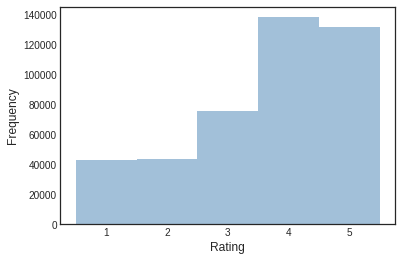

In [45]:
reviews = df_review.select('stars').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]

plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

Quite generous public from Toronto. Most ratings are above 3. Now lets see the the distrubtion of ratings of each restaurants. 

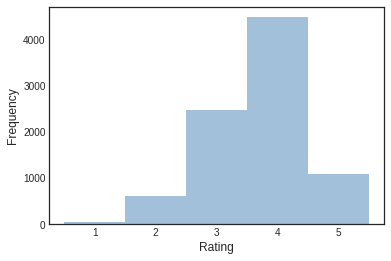

In [50]:
restaurant_reviews = df_business.select('stars_restaurant').collect()
restaurant_reviews_list = [restaurant_reviews[i][0] for i in range(len(restaurant_reviews))]


plt.hist(restaurant_reviews_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

Here were see a more normally distributed curve. Nevertheless most restaurants do pretty well.
Now lets visualize what are the most popular type of restaurants in Toronto. What kind of food do they serve? We will create a wordcloud. 

In [10]:
restaurant_categories = df_business.select('categories').collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]

In [11]:
text = " ".join(review for review in restaurant_categories_list)

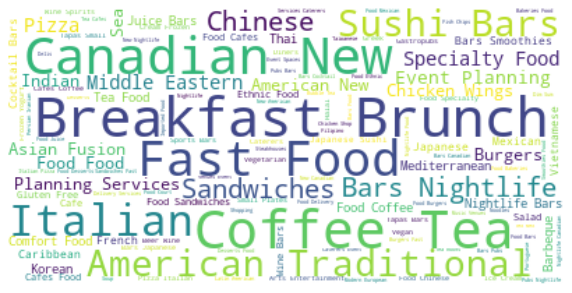

In [12]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('bars', "")
text = text.replace('food', "")


# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

> ## Convert String to index

Before starting the modelling process we must convert all columns that will be used in the model to integer. This is compulsory for the ALS model from pyspark.  The columns that need to be converted are the `business_id` and `user_id`. 

We use the `StringIndexer` function imported in from `pyspark.ml.feature`. 

In [13]:
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_review).transform(df_review)
transformed.select(['business_id', 'user_id','business_id_index', 'user_id_index'])

DataFrame[business_id: string, user_id: string, business_id_index: double, user_id_index: double]

## Split Dataset in train and test


In [14]:
(training, test) = transformed.randomSplit([0.8, 0.2])

## Create ALS model


Alternating Least Square is a matrix factorization algorithm implemented in Apache Spark ML and built for a larges-scale collaborative filtering problems. 


#### Matrix factorization (or decomposition)

The basic idea is to decompose a matrix in smaller parts in the same way we can do for a number. For instance, we can say that the number four can be decomposed in two times two $(4 = 2 x 2)$. In the same way we can do a decomposition of a matrix. 

Here is an example how can we decompose a matrix that has ratings for restaurants by clients:
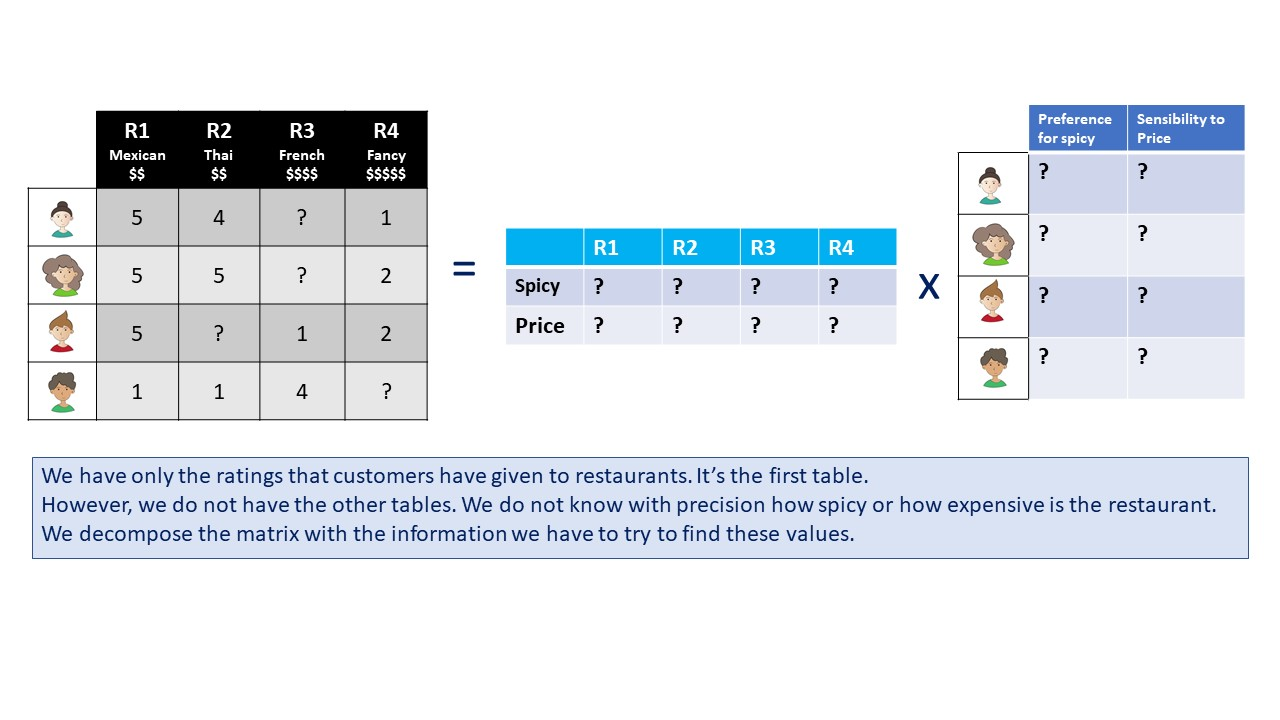

If we are able to find the hidden matrices, we will be able to calculate the expected rating that every client will give to each restaurant. This is our goal with the algorith.


#### But how to find the hidden matrices? 

The math in this process is extensive and is not our goal to discuss it in here. You can read it about in [here](https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea). It is very a very similar process to the stochastic gradient descent. 


#### Parameters (from Apache [Spark](http://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html))
*- **numBlocks** is the number of blocks the users and items will be partitioned into in order to parallelize computation (defaults to 10).*<br>
*- **rank** is the number of latent factors in the model (defaults to 10).*<br>
*- **maxIter** is the maximum number of iterations to run (defaults to 10).*<br>
*- **regParam** specifies the regularization parameter in ALS (defaults to 1.0).*<br>
*- **implicitPrefs** specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).*<br>
*- **alpha** is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).*<br>
*- **nonnegative** specifies whether or not to use nonnegative constraints for least squares (defaults to false).*








In [15]:
als=ALS(maxIter=5,
        regParam=0.09,
        rank=25,
        userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)

model=als.fit(training)

## Evaluate RMSE

In [16]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

RMSE=1.3651734482322269


Our model is doing pretty well. We have are guessing on a pretty good band with a 1.36 average squared error. Lets see an applied case of a recommendation for a customer.

## Visualize Recommendations

Now we visualise recommendations for user 30 (could be any other). 

In [54]:
test = model.recommendForAllUsers(20).filter(col('user_id_index')==30).select("recommendations").collect()
topRestaurants = []
for item in test[0][0]:        
    topRestaurants.append(item.business_id_index)
    
schema = StructType([StructField("business_id_index",IntegerType(),True)])
restaurants = spark.createDataFrame(topRestaurants,IntegerType()).toDF("business_id_index")


transformed\
.select(['business_id', 'user_id', 'stars', 'categories'])\
.filter(col('user_id_index')==30)\
.show()

restaurants\
.join(transformed, on = 'business_id_index', how = 'inner')\
.select(['business_id', 'stars', 'categories', 'name'])\
.drop_duplicates(subset=['name'])\
.show()



+--------------------+--------------------+-----+--------------------+
|         business_id|             user_id|stars|          categories|
+--------------------+--------------------+-----+--------------------+
|9XLH_grfIYKR7d5ZT...|i6V3NyTdkBVwPpH7r...|  2.0|Restaurants, Ital...|
|A7waf6G3cvnLfAqKe...|i6V3NyTdkBVwPpH7r...|  2.0|Restaurants, Italian|
|kuJRRmmmDUXqwM6kN...|i6V3NyTdkBVwPpH7r...|  4.0|Nightlife, Food, ...|
|aEnoF_79jQE83s-I7...|i6V3NyTdkBVwPpH7r...|  3.0|Food, Restaurants...|
|d4bVdEDwxmyB0M-w5...|i6V3NyTdkBVwPpH7r...|  4.0|Breakfast & Brunc...|
|28adZ4lsuUeVB2aWz...|i6V3NyTdkBVwPpH7r...|  5.0|Bars, Food, Gastr...|
|cTbFJzHQzFSX-z3JF...|i6V3NyTdkBVwPpH7r...|  4.0|Restaurants, Amer...|
|eQCYur0033RkZdh5V...|i6V3NyTdkBVwPpH7r...|  3.0|Italian, Breakfas...|
|Ycp3Agr7dt71TZkeK...|i6V3NyTdkBVwPpH7r...|  3.0|French, Breakfast...|
|7HrCELR6uv2HkgL7a...|i6V3NyTdkBVwPpH7r...|  2.0|Restaurants, Seaf...|
|sHXIiGercy22UVpwM...|i6V3NyTdkBVwPpH7r...|  4.0|Comfort Food, Nig...|
|nDn2h